# Task 1: Preprocess and Explore the Data

**Objective:** Load, clean, and understand the financial data to prepare it for modeling.

This notebook covers:
- Extracting historical financial data using YFinance
- Data cleaning and preprocessing
- Exploratory Data Analysis (EDA)
- Stationarity testing
- Risk metrics calculation

In [1]:
import sys
import os
from pathlib import Path

# Add project root and src to path
project_root = Path.cwd().parent
src_path = project_root / "src"
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

# Imports
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Custom imports
from src.config.settings import settings
from src.utils.plotter import Plotter

# Initialize plotter
plotter = Plotter()

print(f"Project root: {project_root}")
print(f"Raw data directory: {settings.raw_data_dir}")
print(f"Figures directory: {settings.figures_dir}")

Project root: c:\BackUp\web-projects\tenx\financial-portfolio-forecasting
Raw data directory: C:\BackUp\web-projects\tenx\financial-portfolio-forecasting\data\raw
Figures directory: C:\BackUp\web-projects\tenx\financial-portfolio-forecasting\outputs\figures


## 1. Data Extraction

Extract historical financial data for TSLA, BND, and SPY from YFinance covering January 1, 2015 to January 15, 2026.

In [2]:
def fetch_financial_data(ticker, start_date, end_date):
    """Fetch historical financial data for a given ticker."""
    print(f"Fetching data for {ticker} from {start_date} to {end_date}")
    # Use auto_adjust=False to get Adj Close column
    data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)
    print(f"Data shape: {data.shape}")
    print(f"Columns: {data.columns.tolist()}")
    print(f"Sample data:\n{data.head()}")
    return data

# Ensure raw data directory exists
settings.raw_data_dir.mkdir(parents=True, exist_ok=True)

# Fetch data for each asset
tickers = settings.tickers
start_date = settings.start_date
end_date = settings.end_date

data_dict = {}
for ticker in tickers:
    data = fetch_financial_data(ticker, start_date, end_date)
    data_dict[ticker] = data

    # Save individual raw data
    if ticker == "TSLA":
        data.to_csv(settings.tsla_raw_path)
    elif ticker == "BND":
        data.to_csv(settings.bnd_raw_path)
    elif ticker == "SPY":
        data.to_csv(settings.spy_raw_path)

    print(f"Saved {ticker} data: {len(data)} rows")

# Create combined dataset
combined_data = []
for ticker, data in data_dict.items():
    df = data.copy()
    df['Ticker'] = ticker
    df['Date'] = df.index
    df = df.reset_index(drop=True)
    combined_data.append(df)

combined_df = pd.concat(combined_data, ignore_index=True)
combined_df.to_csv(settings.combined_raw_path, index=False)

print(f"Combined data saved: {len(combined_df)} rows")
print(f"Data shape: {combined_df.shape}")
print(f"Columns: {combined_df.columns.tolist()}")

Fetching data for TSLA from 2015-01-01 to 2026-01-15


[*********************100%***********************]  1 of 1 completed


Data shape: (2775, 6)
Columns: [('Adj Close', 'TSLA'), ('Close', 'TSLA'), ('High', 'TSLA'), ('Low', 'TSLA'), ('Open', 'TSLA'), ('Volume', 'TSLA')]
Sample data:
Price       Adj Close      Close       High        Low       Open    Volume
Ticker           TSLA       TSLA       TSLA       TSLA       TSLA      TSLA
Date                                                                       
2015-01-02  14.620667  14.620667  14.883333  14.217333  14.858000  71466000
2015-01-05  14.006000  14.006000  14.433333  13.810667  14.303333  80527500
2015-01-06  14.085333  14.085333  14.280000  13.614000  14.004000  93928500
2015-01-07  14.063333  14.063333  14.318667  13.985333  14.223333  44526000
2015-01-08  14.041333  14.041333  14.253333  14.000667  14.187333  51637500
Saved TSLA data: 2775 rows
Fetching data for BND from 2015-01-01 to 2026-01-15


[*********************100%***********************]  1 of 1 completed


Data shape: (2775, 6)
Columns: [('Adj Close', 'BND'), ('Close', 'BND'), ('High', 'BND'), ('Low', 'BND'), ('Open', 'BND'), ('Volume', 'BND')]
Sample data:
Price       Adj Close      Close       High        Low       Open   Volume
Ticker            BND        BND        BND        BND        BND      BND
Date                                                                      
2015-01-02  60.385963  82.650002  82.690002  82.419998  82.430000  2218800
2015-01-05  60.561340  82.889999  82.919998  82.699997  82.739998  5820100
2015-01-06  60.736656  83.129997  83.379997  83.029999  83.029999  3887600
2015-01-07  60.773178  83.180000  83.279999  83.050003  83.139999  2433400
2015-01-08  60.678223  83.050003  83.110001  82.970001  83.110001  1873400
Saved BND data: 2775 rows
Fetching data for SPY from 2015-01-01 to 2026-01-15


[*********************100%***********************]  1 of 1 completed


Data shape: (2775, 6)
Columns: [('Adj Close', 'SPY'), ('Close', 'SPY'), ('High', 'SPY'), ('Low', 'SPY'), ('Open', 'SPY'), ('Volume', 'SPY')]
Sample data:
Price        Adj Close       Close        High         Low        Open  \
Ticker             SPY         SPY         SPY         SPY         SPY   
Date                                                                     
2015-01-02  170.589615  205.429993  206.880005  204.179993  206.380005   
2015-01-05  167.508850  201.720001  204.369995  201.350006  204.169998   
2015-01-06  165.931076  199.820007  202.720001  198.860001  202.089996   
2015-01-07  167.998749  202.309998  202.720001  200.880005  201.419998   
2015-01-08  170.979904  205.899994  206.160004  203.990005  204.009995   

Price          Volume  
Ticker            SPY  
Date                   
2015-01-02  121465900  
2015-01-05  169632600  
2015-01-06  209151400  
2015-01-07  125346700  
2015-01-08  147217800  
Saved SPY data: 2775 rows
Combined data saved: 8325 rows
Data

In [3]:
# Display data overview
print("Data Overview:")
for ticker, data in data_dict.items():
    print(f"\n{ticker}:")
    print(f"  Shape: {data.shape}")
    print(f"  Date range: {data.index.min()} to {data.index.max()}")
    print(f"  Columns: {data.columns.tolist()}")
    print(f"  Missing values: {data.isnull().sum().sum()}")

# Display sample of combined data
print("\nCombined Data Sample:")
display(combined_df.head())

Data Overview:

TSLA:
  Shape: (2775, 6)
  Date range: 2015-01-02 00:00:00 to 2026-01-14 00:00:00
  Columns: [('Adj Close', 'TSLA'), ('Close', 'TSLA'), ('High', 'TSLA'), ('Low', 'TSLA'), ('Open', 'TSLA'), ('Volume', 'TSLA')]
  Missing values: 0

BND:
  Shape: (2775, 6)
  Date range: 2015-01-02 00:00:00 to 2026-01-14 00:00:00
  Columns: [('Adj Close', 'BND'), ('Close', 'BND'), ('High', 'BND'), ('Low', 'BND'), ('Open', 'BND'), ('Volume', 'BND')]
  Missing values: 0

SPY:
  Shape: (2775, 6)
  Date range: 2015-01-02 00:00:00 to 2026-01-14 00:00:00
  Columns: [('Adj Close', 'SPY'), ('Close', 'SPY'), ('High', 'SPY'), ('Low', 'SPY'), ('Open', 'SPY'), ('Volume', 'SPY')]
  Missing values: 0

Combined Data Sample:


Price,Adj Close,Close,High,Low,Open,Volume,Ticker,Date,Adj Close,Close,High,Low,Open,Volume,Adj Close,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA,,,BND,BND,BND,BND,BND,BND,SPY,SPY,SPY,SPY,SPY,SPY
0,14.620667,14.620667,14.883333,14.217333,14.858000,71466000.0,TSLA,2015-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14.006000,14.006000,14.433333,13.810667,14.303333,80527500.0,TSLA,2015-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,14.085333,14.085333,14.280000,13.614000,14.004000,93928500.0,TSLA,2015-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,14.063333,14.063333,14.318667,13.985333,14.223333,44526000.0,TSLA,2015-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,14.041333,14.041333,14.253333,14.000667,14.187333,51637500.0,TSLA,2015-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Data Cleaning and Preprocessing

Check basic statistics, handle missing values, and ensure proper data types.

In [4]:
# Data cleaning function
def clean_financial_data(data_dict):
    """Clean and preprocess financial data."""
    cleaned_data = {}

    for ticker, data in data_dict.items():
        df = data.copy()

        # Check data types
        print(f"\n{ticker} - Original dtypes:")
        print(df.dtypes)
        print(f"Columns: {df.columns.tolist()}")

        # Handle MultiIndex columns if present (yfinance returns these)
        if isinstance(df.columns, pd.MultiIndex):
            # For yfinance MultiIndex, we want the price types (level 0), not ticker names (level 1)
            df.columns = df.columns.get_level_values(0)
            print(f"Flattened MultiIndex columns: {df.columns.tolist()}")

        # Handle missing values
        missing_before = df.isnull().sum().sum()
        print(f"Missing values before cleaning: {missing_before}")

        # Forward fill missing values (common for time series)
        df = df.ffill()

        # If still missing (e.g., at the beginning), use backward fill
        df = df.bfill()

        missing_after = df.isnull().sum().sum()
        print(f"Missing values after cleaning: {missing_after}")

        # Ensure Date is datetime index
        if not isinstance(df.index, pd.DatetimeIndex):
            df.index = pd.to_datetime(df.index)

        # Add basic calculated columns
        df['Daily_Return'] = df['Adj Close'].pct_change()
        df['Log_Return'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))

        # Remove any remaining NaN rows (from return calculations)
        df = df.dropna()

        cleaned_data[ticker] = df
        print(f"Final shape: {df.shape}")

    return cleaned_data

# Clean the data
cleaned_data_dict = clean_financial_data(data_dict)

# Display cleaned data info
for ticker, data in cleaned_data_dict.items():
    print(f"\n{ticker} cleaned data:")
    print(data.head())
    print(f"Date range: {data.index.min()} to {data.index.max()}")


TSLA - Original dtypes:
Price      Ticker
Adj Close  TSLA      float64
Close      TSLA      float64
High       TSLA      float64
Low        TSLA      float64
Open       TSLA      float64
Volume     TSLA        int64
dtype: object
Columns: [('Adj Close', 'TSLA'), ('Close', 'TSLA'), ('High', 'TSLA'), ('Low', 'TSLA'), ('Open', 'TSLA'), ('Volume', 'TSLA')]
Flattened MultiIndex columns: ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
Missing values before cleaning: 0
Missing values after cleaning: 0
Final shape: (2774, 8)

BND - Original dtypes:
Price      Ticker
Adj Close  BND       float64
Close      BND       float64
High       BND       float64
Low        BND       float64
Open       BND       float64
Volume     BND         int64
dtype: object
Columns: [('Adj Close', 'BND'), ('Close', 'BND'), ('High', 'BND'), ('Low', 'BND'), ('Open', 'BND'), ('Volume', 'BND')]
Flattened MultiIndex columns: ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
Missing values before cleaning: 0

## 3. Exploratory Data Analysis (EDA)

Visualize closing prices, analyze volatility, and identify patterns.

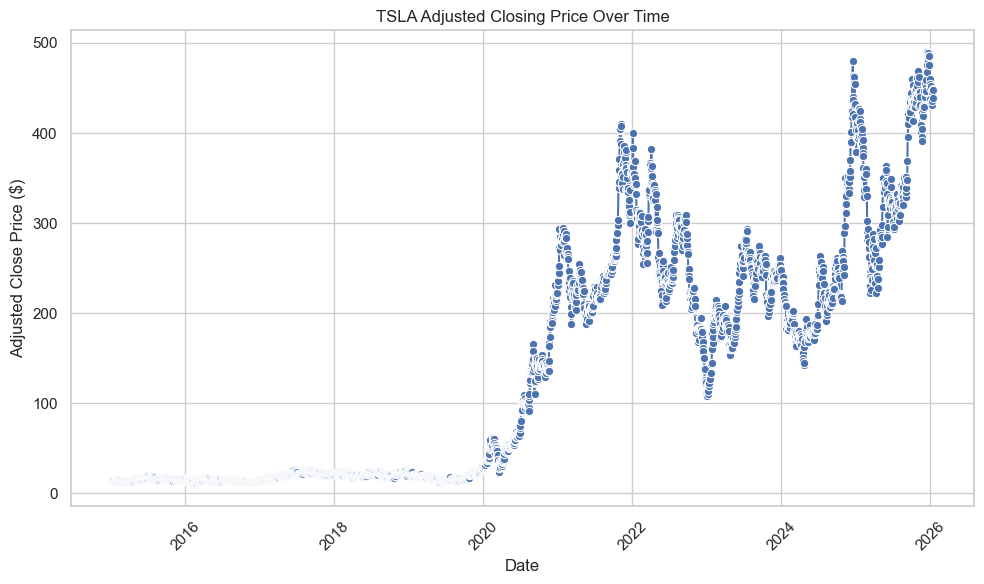

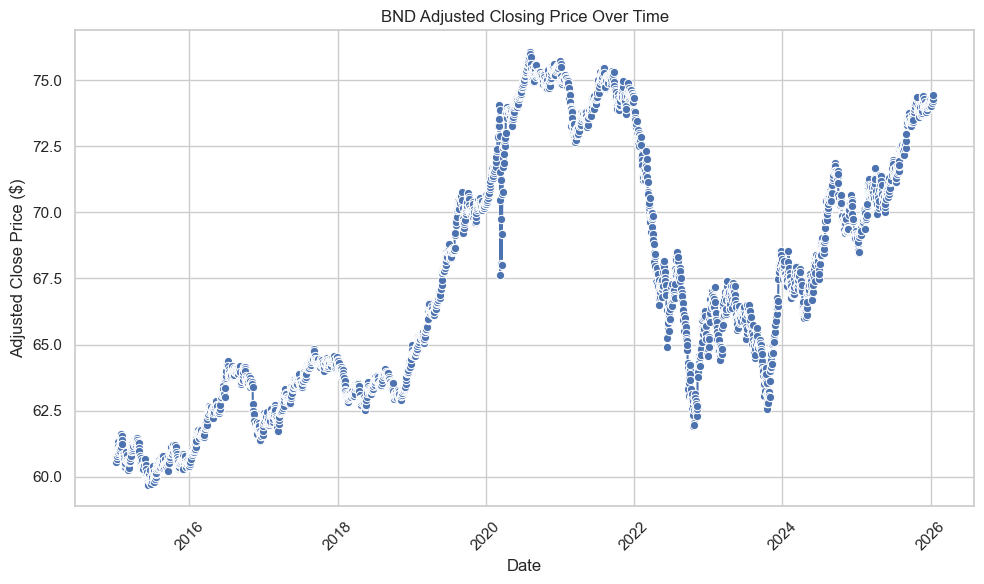

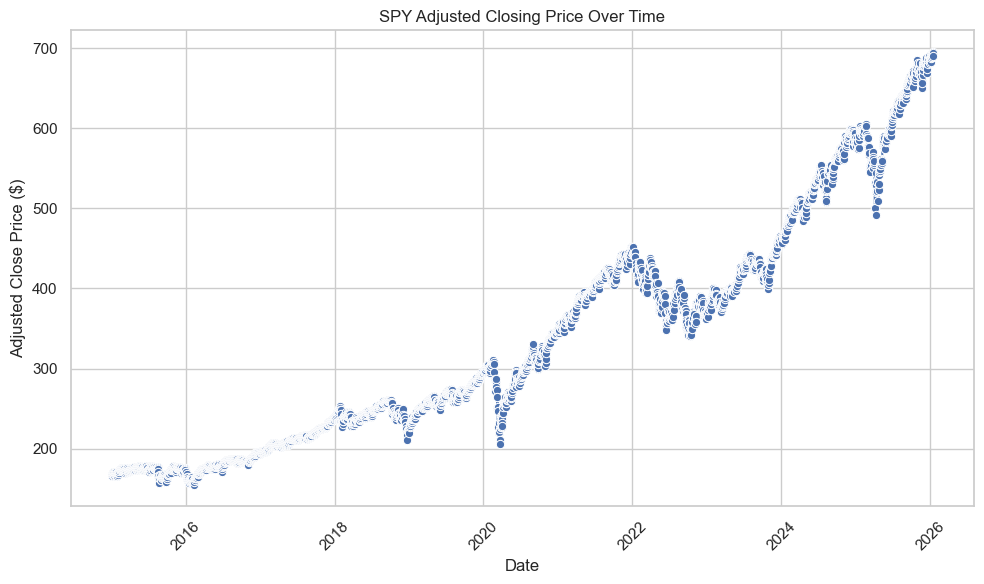

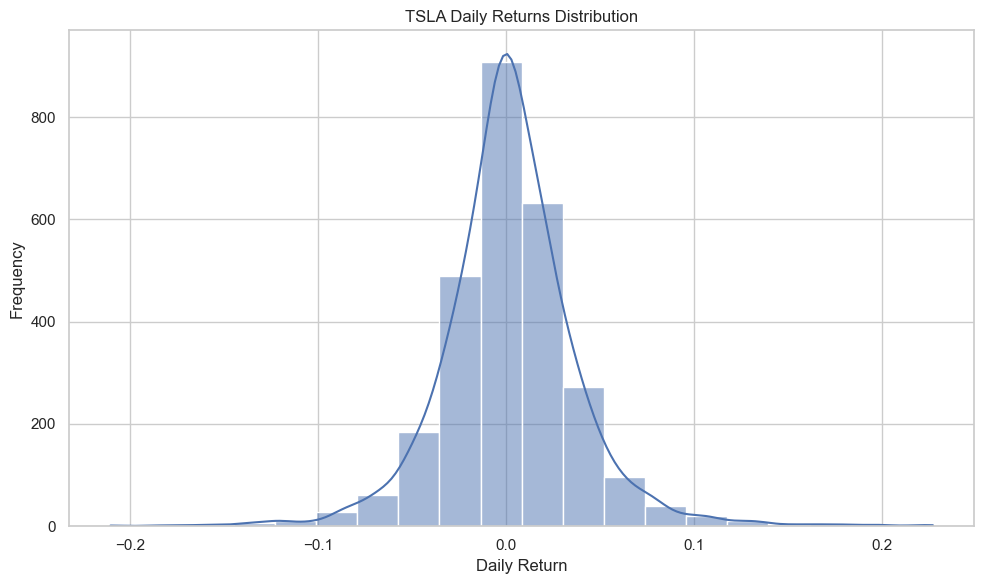

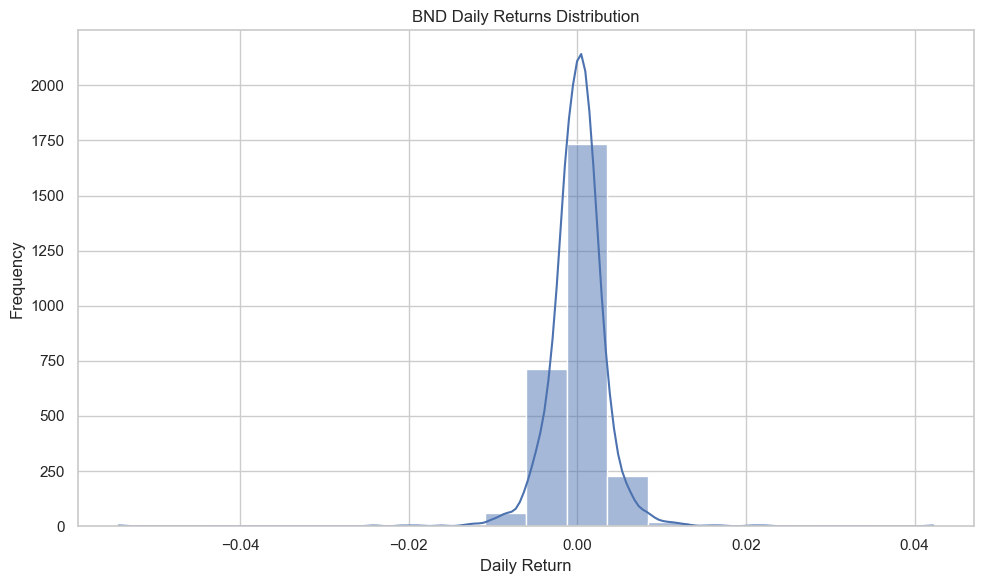

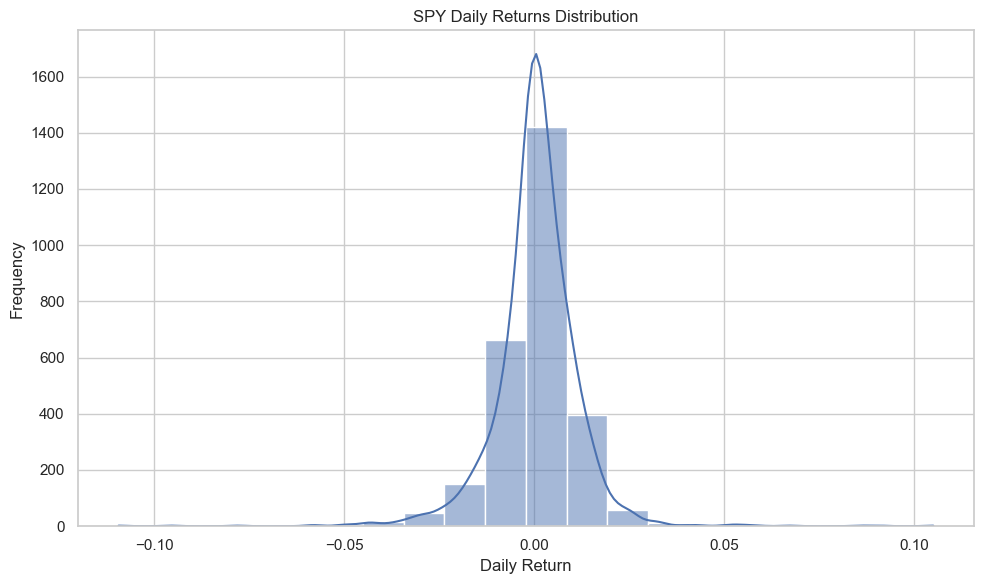

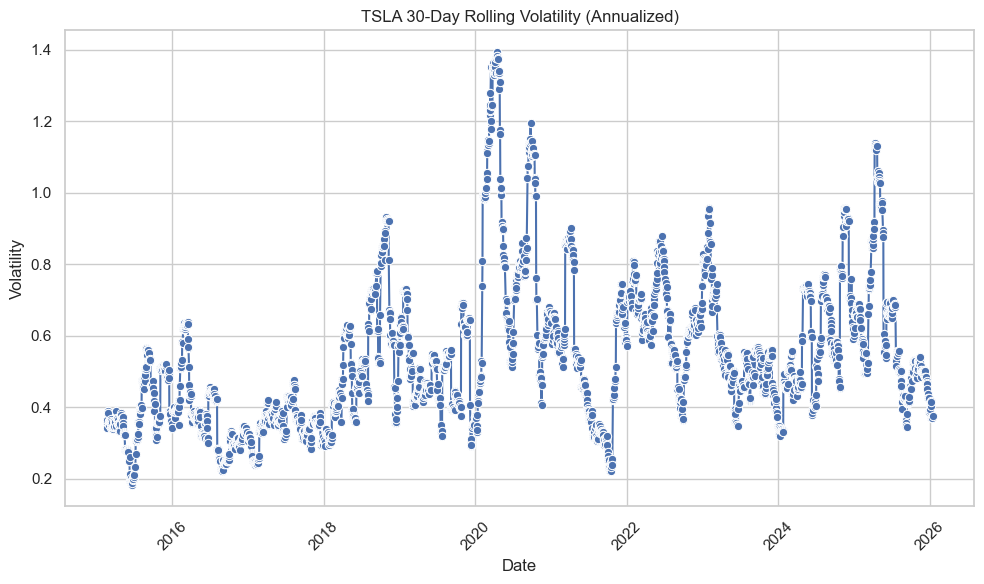

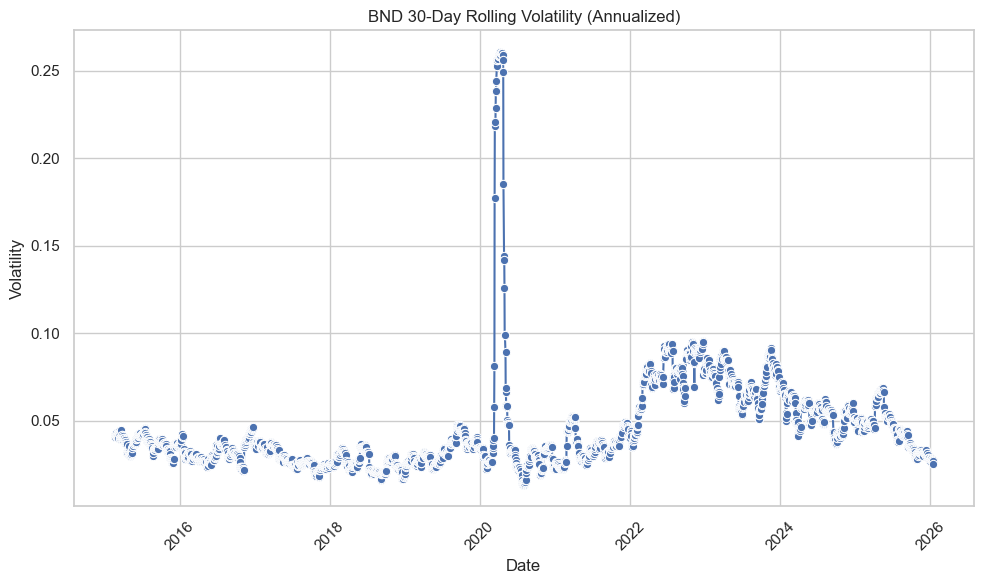

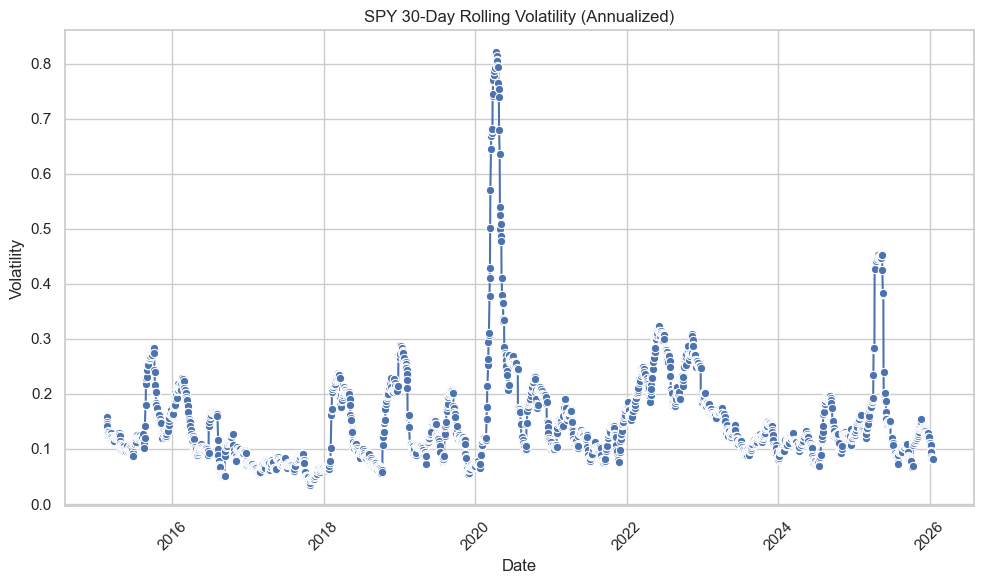

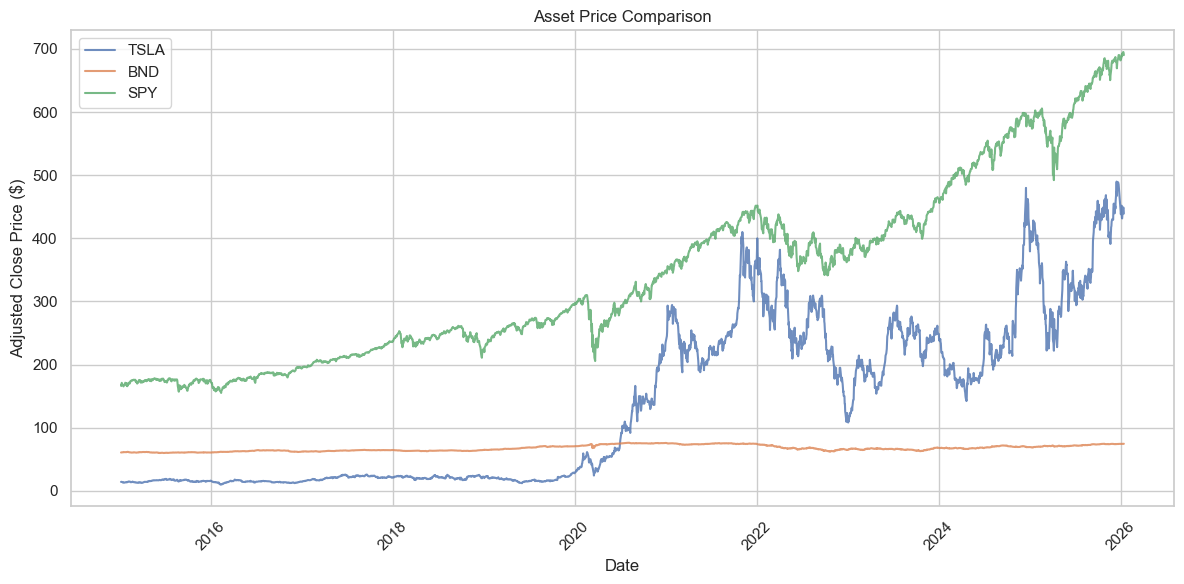

In [5]:
# Create combined dataframe for plotting
plot_data = []
for ticker, data in cleaned_data_dict.items():
    df = data[['Adj Close', 'Daily_Return']].copy()
    df['Ticker'] = ticker
    df['Date'] = df.index
    plot_data.append(df.reset_index(drop=True))

plot_df = pd.concat(plot_data, ignore_index=True)

# 1. Closing Price Trends
for ticker in settings.tickers:
    ticker_data = cleaned_data_dict[ticker]
    plotter.plot_time_series(
        ticker_data,
        date_col='Date',
        value_col='Adj Close',
        title=f"{ticker} Adjusted Closing Price Over Time",
        ylabel="Adjusted Close Price ($)"
    )

# 2. Daily Returns Distribution
for ticker in settings.tickers:
    ticker_data = cleaned_data_dict[ticker]
    plotter.plot_histogram(
        ticker_data,
        column='Daily_Return',
        title=f"{ticker} Daily Returns Distribution",
        xlabel="Daily Return",
        ylabel="Frequency"
    )

# 3. Volatility Analysis - Rolling Standard Deviation
for ticker in settings.tickers:
    ticker_data = cleaned_data_dict[ticker].copy()
    ticker_data['Rolling_Volatility_30D'] = ticker_data['Daily_Return'].rolling(window=30).std() * np.sqrt(252)  # Annualized

    plotter.plot_time_series(
        ticker_data,
        date_col='Date',
        value_col='Rolling_Volatility_30D',
        title=f"{ticker} 30-Day Rolling Volatility (Annualized)",
        ylabel="Volatility"
    )

# 4. Compare Adjusted Close Prices
price_data = {ticker: cleaned_data_dict[ticker]['Adj Close'] for ticker in settings.tickers}
plotter.plot_multi_line_time_series(
    price_data,
    title="Asset Price Comparison",
    ylabel="Adjusted Close Price ($)"
)

## 4. Stationarity Analysis

Perform Augmented Dickey-Fuller tests on closing prices and returns to check for stationarity.


Stationarity Tests for TSLA

TSLA - Adjusted Close Prices
ADF Statistic: -0.7803
p-value: 0.8249
Critical Values:
  1%: -3.4327
  5%: -2.8626
  10%: -2.5673
Result: Non-stationary (fail to reject null hypothesis)

TSLA - Daily Returns
ADF Statistic: -53.0196
p-value: 0.0000
Critical Values:
  1%: -3.4327
  5%: -2.8626
  10%: -2.5673
Result: Stationary (reject null hypothesis)

Stationarity Tests for BND

BND - Adjusted Close Prices
ADF Statistic: -1.0297
p-value: 0.7423
Critical Values:
  1%: -3.4327
  5%: -2.8626
  10%: -2.5673
Result: Non-stationary (fail to reject null hypothesis)

BND - Daily Returns
ADF Statistic: -10.4337
p-value: 0.0000
Critical Values:
  1%: -3.4327
  5%: -2.8626
  10%: -2.5673
Result: Stationary (reject null hypothesis)

Stationarity Tests for SPY

SPY - Adjusted Close Prices
ADF Statistic: 1.1820
p-value: 0.9959
Critical Values:
  1%: -3.4327
  5%: -2.8626
  10%: -2.5673
Result: Non-stationary (fail to reject null hypothesis)

SPY - Daily Returns
ADF Statist

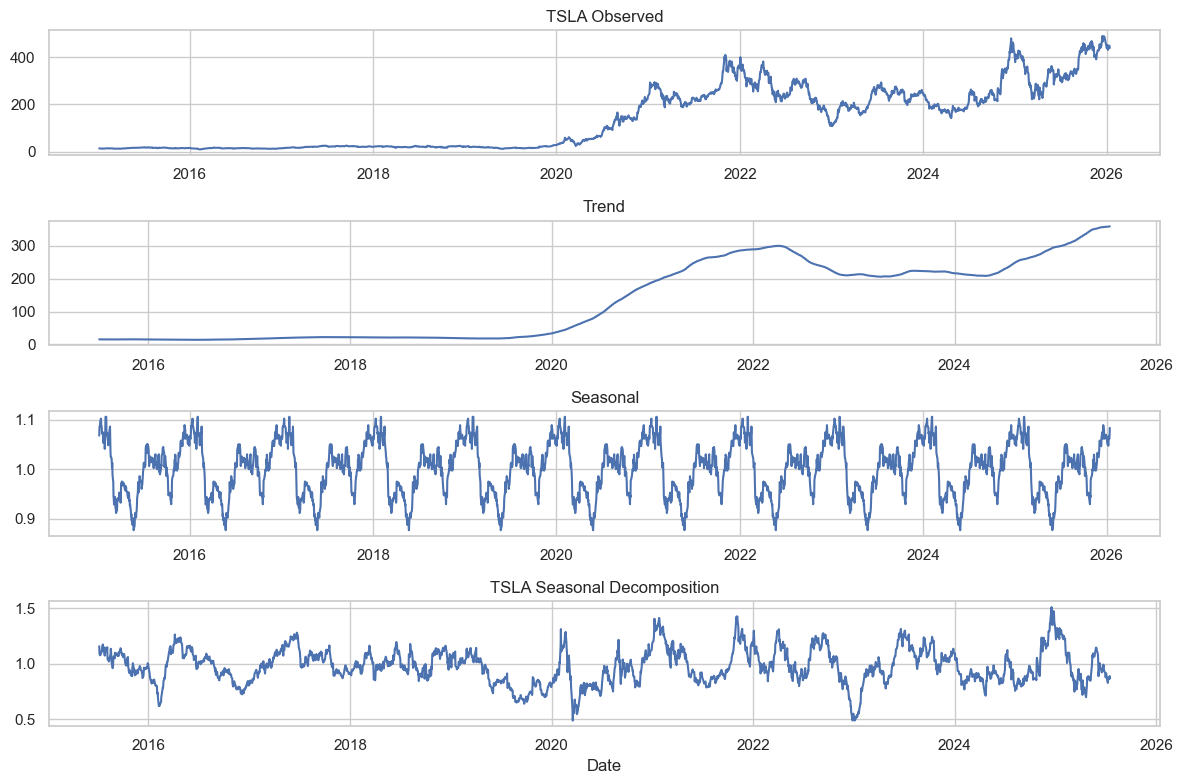

In [6]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

def perform_adf_test(series, title):
    """Perform Augmented Dickey-Fuller test and return results."""
    result = adfuller(series.dropna())
    print(f"\n{title}")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print(f"Critical Values:")
    for key, value in result[4].items():
        print(f"  {key}: {value:.4f}")

    if result[1] < 0.05:
        print("Result: Stationary (reject null hypothesis)")
    else:
        print("Result: Non-stationary (fail to reject null hypothesis)")

    return result

# Test stationarity for each asset
stationarity_results = {}

for ticker in settings.tickers:
    data = cleaned_data_dict[ticker]
    print(f"\n{'='*50}")
    print(f"Stationarity Tests for {ticker}")
    print(f"{'='*50}")

    # Test closing prices
    price_result = perform_adf_test(data['Adj Close'], f"{ticker} - Adjusted Close Prices")

    # Test returns (should be stationary)
    return_result = perform_adf_test(data['Daily_Return'], f"{ticker} - Daily Returns")

    stationarity_results[ticker] = {
        'prices': price_result,
        'returns': return_result
    }

# Seasonal decomposition for TSLA (most volatile)
tsla_data = cleaned_data_dict['TSLA']
decomposition = seasonal_decompose(tsla_data['Adj Close'], model='multiplicative', period=252)  # ~1 year

plotter.plot_seasonal_decomposition(decomposition, title_prefix="TSLA")

## 4. Outlier Detection

Analyze days with unusually high or low returns to identify significant market events and anomalies.


OUTLIER ANALYSIS for TSLA
Total trading days: 2774
Outliers (z-score > 3): 44 days
Extreme returns (>5% or <-5%): 348 days
.4f
.4f

Top 5 outlier dates by magnitude:
.4f
.4f
.4f
.4f
.4f

Extreme return dates (>5% absolute):
.4f
.4f
.4f
.4f
.4f
.4f
.4f
.4f
.4f
.4f

OUTLIER ANALYSIS for BND
Total trading days: 2774
Outliers (z-score > 3): 32 days
Extreme returns (>5% or <-5%): 1 days
.4f
.4f

Top 5 outlier dates by magnitude:
.4f
.4f
.4f
.4f
.4f

Extreme return dates (>5% absolute):
.4f

OUTLIER ANALYSIS for SPY
Total trading days: 2774
Outliers (z-score > 3): 39 days
Extreme returns (>5% or <-5%): 15 days
.4f
.4f

Top 5 outlier dates by magnitude:
.4f
.4f
.4f
.4f
.4f

Extreme return dates (>5% absolute):
.4f
.4f
.4f
.4f
.4f
.4f
.4f
.4f
.4f
.4f


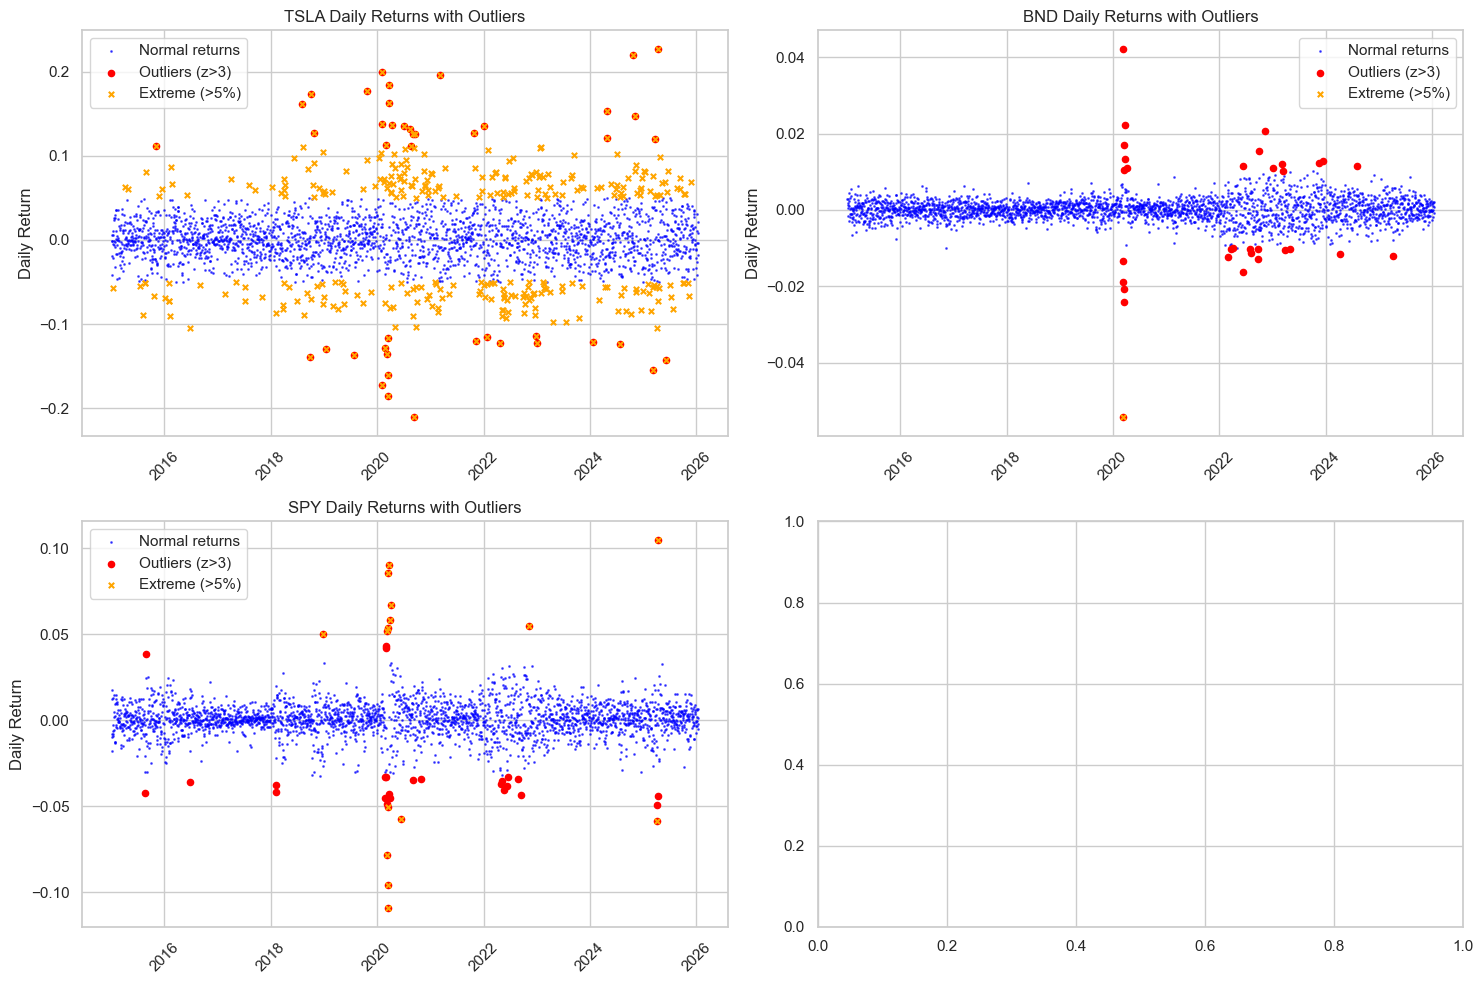


Outlier analysis plot saved to: C:\BackUp\web-projects\tenx\financial-portfolio-forecasting\outputs\figures\return_outliers_analysis.png


In [7]:
# Outlier detection for extreme returns
def detect_return_outliers(returns, threshold=3.0):
    """Detect outliers using z-score method."""
    mean_return = returns.mean()
    std_return = returns.std()
    z_scores = (returns - mean_return) / std_return
    
    outliers = returns[abs(z_scores) > threshold]
    return outliers, z_scores

outlier_summary = {}

for ticker in settings.tickers:
    data = cleaned_data_dict[ticker]
    returns = data['Daily_Return']
    
    # Detect outliers using z-score method
    outliers, z_scores = detect_return_outliers(returns, threshold=3.0)
    
    # Also identify extreme returns (>5% or <-5%)
    extreme_returns = returns[abs(returns) > 0.05]
    
    outlier_summary[ticker] = {
        'outlier_count': len(outliers),
        'extreme_return_count': len(extreme_returns),
        'max_return': returns.max(),
        'min_return': returns.min(),
        'outlier_dates': outliers.index.tolist() if len(outliers) > 0 else [],
        'extreme_dates': extreme_returns.index.tolist() if len(extreme_returns) > 0 else []
    }
    
    print(f"\n{'='*50}")
    print(f"OUTLIER ANALYSIS for {ticker}")
    print(f"{'='*50}")
    print(f"Total trading days: {len(returns)}")
    print(f"Outliers (z-score > 3): {len(outliers)} days")
    print(f"Extreme returns (>5% or <-5%): {len(extreme_returns)} days")
    print(".4f")
    print(".4f")
    
    if len(outliers) > 0:
        print(f"\nTop 5 outlier dates by magnitude:")
        top_outliers = outliers.abs().nlargest(5)
        for date, return_val in top_outliers.items():
            print(".4f")
    
    if len(extreme_returns) > 0:
        print(f"\nExtreme return dates (>5% absolute):")
        for date in extreme_returns.index[:10]:  # Show first 10
            ret_val = extreme_returns.loc[date]
            print(".4f")

# Visualize outlier distribution
outlier_plot_data = {}
for ticker in settings.tickers:
    data = cleaned_data_dict[ticker]
    returns = data['Daily_Return']
    
    # Detect outliers and extreme returns
    outliers, _ = detect_return_outliers(returns, threshold=3.0)
    extreme_returns = returns[abs(returns) > 0.05]
    
    outlier_plot_data[ticker] = (returns, outliers, extreme_returns)

plotter.plot_outlier_scatter_subplots(
    outlier_plot_data,
    title="Return Outliers Analysis"
)

print(f"\nOutlier analysis plot saved to: {settings.figures_dir / 'return_outliers_analysis.png'}")

## 5. Stationarity Analysis

Perform Augmented Dickey-Fuller tests on closing prices and returns to check for stationarity.


Stationarity Tests for TSLA

TSLA - Adjusted Close Prices
ADF Statistic: -0.7803
p-value: 0.8249
Critical Values:
  1%: -3.4327
  5%: -2.8626
  10%: -2.5673
Result: Non-stationary (fail to reject null hypothesis)

TSLA - Daily Returns
ADF Statistic: -53.0196
p-value: 0.0000
Critical Values:
  1%: -3.4327
  5%: -2.8626
  10%: -2.5673
Result: Stationary (reject null hypothesis)

Stationarity Tests for BND

BND - Adjusted Close Prices
ADF Statistic: -1.0297
p-value: 0.7423
Critical Values:
  1%: -3.4327
  5%: -2.8626
  10%: -2.5673
Result: Non-stationary (fail to reject null hypothesis)

BND - Daily Returns
ADF Statistic: -10.4337
p-value: 0.0000
Critical Values:
  1%: -3.4327
  5%: -2.8626
  10%: -2.5673
Result: Stationary (reject null hypothesis)

Stationarity Tests for SPY

SPY - Adjusted Close Prices
ADF Statistic: 1.1820
p-value: 0.9959
Critical Values:
  1%: -3.4327
  5%: -2.8626
  10%: -2.5673
Result: Non-stationary (fail to reject null hypothesis)

SPY - Daily Returns
ADF Statist

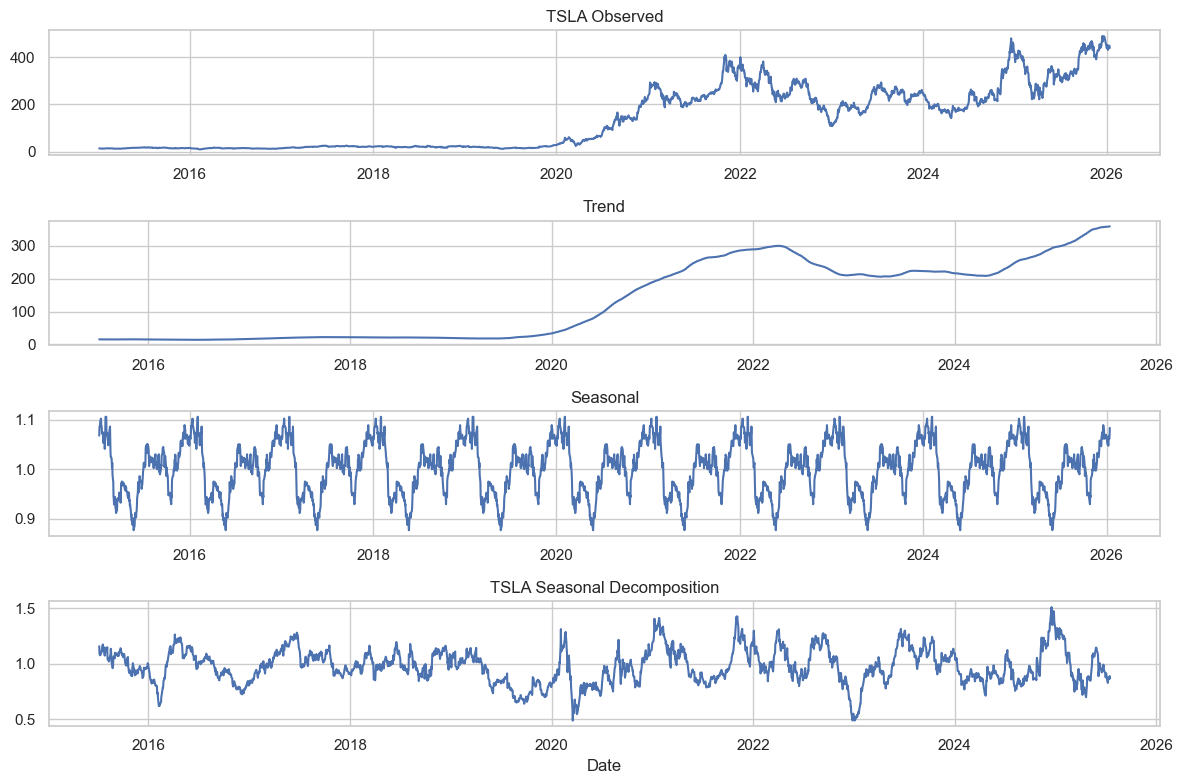

In [8]:
# Test stationarity for each asset
stationarity_results = {}

for ticker in settings.tickers:
    data = cleaned_data_dict[ticker]
    print(f"\n{'='*50}")
    print(f"Stationarity Tests for {ticker}")
    print(f"{'='*50}")

    # Test closing prices
    price_result = perform_adf_test(data['Adj Close'], f"{ticker} - Adjusted Close Prices")

    # Test returns (should be stationary)
    return_result = perform_adf_test(data['Daily_Return'], f"{ticker} - Daily Returns")

    stationarity_results[ticker] = {
        'prices': price_result,
        'returns': return_result
    }

# Seasonal decomposition for TSLA (most volatile)
tsla_data = cleaned_data_dict['TSLA']
decomposition = seasonal_decompose(tsla_data['Adj Close'], model='multiplicative', period=252)  # ~1 year

plotter.plot_seasonal_decomposition(decomposition, title_prefix="TSLA")

## 6. Risk Metrics Calculation

Calculate Value at Risk (VaR) and Sharpe Ratio for each asset.

Risk Metrics Summary:
      VaR_95  VaR_99  Sharpe_Ratio  Annual_Volatility  Max_Drawdown  \
TSLA  0.0525  0.0904        0.7885             0.5769       -0.7363   
BND   0.0048  0.0087        0.0081             0.0536       -0.1858   
SPY   0.0167  0.0321        0.6914             0.1777       -0.3372   

      Mean_Return  
TSLA       0.4749  
BND        0.0204  
SPY        0.1429  


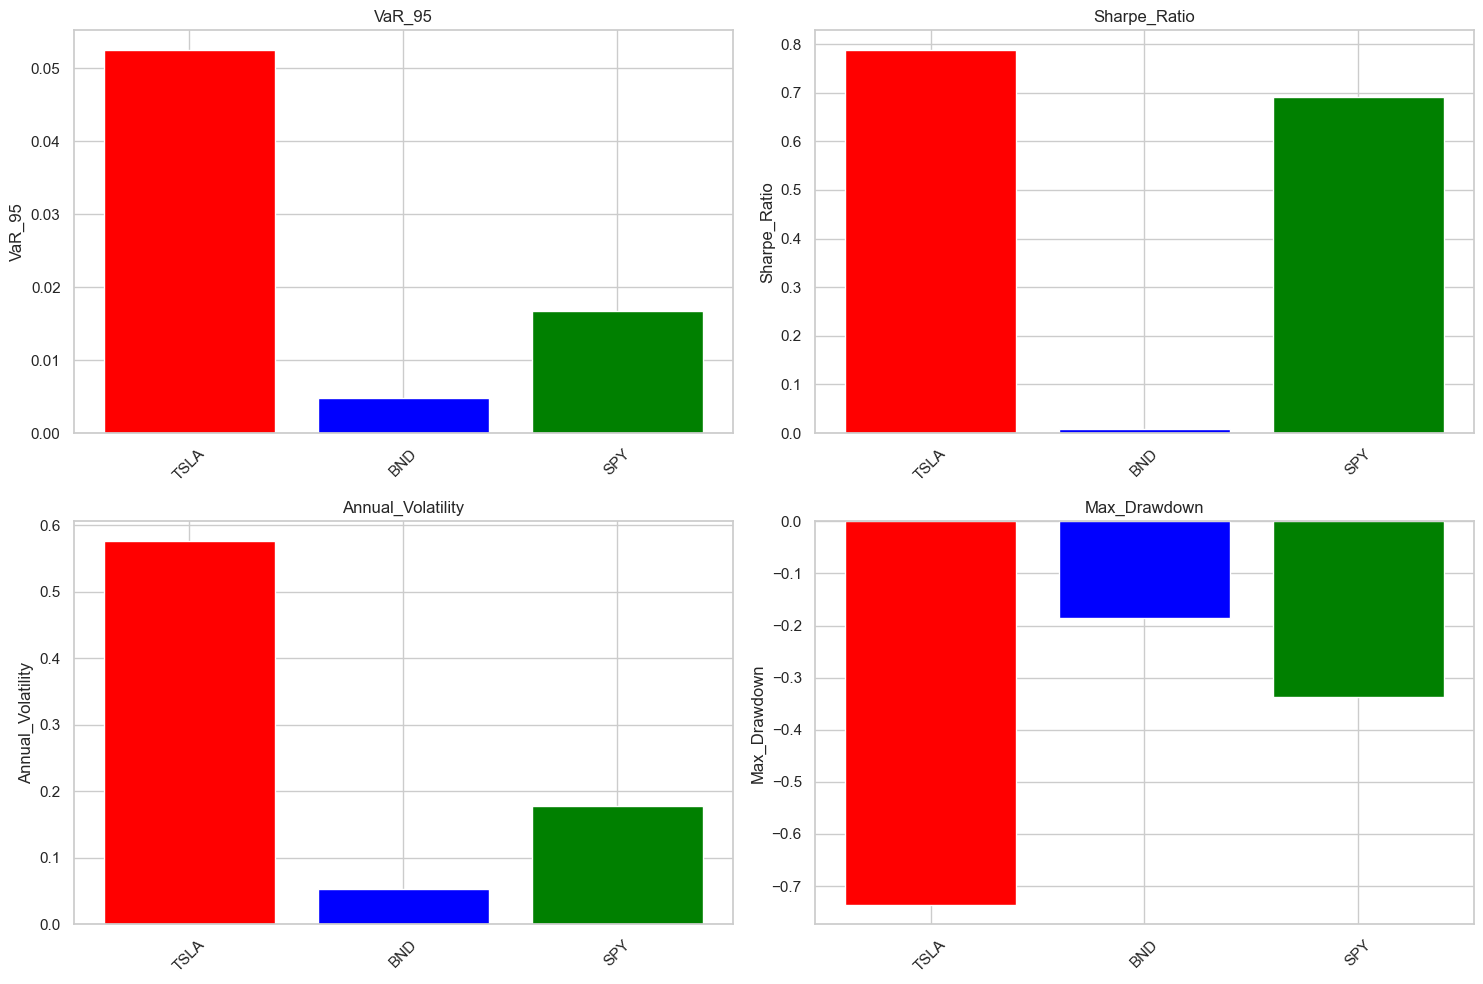

In [9]:
def calculate_var(returns, confidence_level=0.95):
    """Calculate Value at Risk using historical simulation."""
    return -np.percentile(returns.dropna(), (1 - confidence_level) * 100)

def calculate_sharpe_ratio(returns, risk_free_rate=0.02):
    """Calculate Sharpe Ratio (annualized)."""
    excess_returns = returns - risk_free_rate/252  # Daily risk-free rate
    return np.sqrt(252) * excess_returns.mean() / returns.std()

# Calculate risk metrics for each asset
risk_metrics = {}

for ticker in settings.tickers:
    data = cleaned_data_dict[ticker]
    returns = data['Daily_Return']

    var_95 = calculate_var(returns, 0.95)
    var_99 = calculate_var(returns, 0.99)
    sharpe = calculate_sharpe_ratio(returns)
    volatility = returns.std() * np.sqrt(252)  # Annualized
    max_drawdown = (data['Adj Close'] / data['Adj Close'].expanding().max() - 1).min()

    risk_metrics[ticker] = {
        'VaR_95': var_95,
        'VaR_99': var_99,
        'Sharpe_Ratio': sharpe,
        'Annual_Volatility': volatility,
        'Max_Drawdown': max_drawdown,
        'Mean_Return': returns.mean() * 252,  # Annualized
    }

# Display risk metrics
risk_df = pd.DataFrame(risk_metrics).T
print("Risk Metrics Summary:")
print(risk_df.round(4))

# Visualize risk metrics
risk_data = {
    'VaR_95': risk_df['VaR_95'],
    'Sharpe_Ratio': risk_df['Sharpe_Ratio'], 
    'Annual_Volatility': risk_df['Annual_Volatility'],
    'Max_Drawdown': risk_df['Max_Drawdown']
}

plotter.plot_multi_bar_comparison(risk_data, title="Risk Metrics Comparison")

## 7. Summary and Key Insights

Document key findings from the EDA and prepare data for modeling.

In [10]:
# Summary statistics
summary_stats = {}
for ticker in settings.tickers:
    data = cleaned_data_dict[ticker]
    summary_stats[ticker] = {
        'Start_Date': data.index.min(),
        'End_Date': data.index.max(),
        'Total_Observations': len(data),
        'Avg_Price': data['Adj Close'].mean(),
        'Price_Volatility': data['Adj Close'].std(),
        'Avg_Daily_Return': data['Daily_Return'].mean(),
        'Return_Volatility': data['Daily_Return'].std(),
        'Skewness': data['Daily_Return'].skew(),
        'Kurtosis': data['Daily_Return'].kurtosis(),
    }

summary_df = pd.DataFrame(summary_stats).T
print("Summary Statistics:")
print(summary_df.round(4))

# Key Insights
print("\n" + "="*60)
print("KEY INSIGHTS FROM TASK 1 - DATA PREPROCESSING AND EXPLORATION")
print("="*60)

print("\n1. DATA QUALITY:")
print(f"   - Successfully extracted {len(settings.tickers)} assets: {', '.join(settings.tickers)}")
print(f"   - Date range: {settings.start_date} to {settings.end_date}")
print("   - No missing values after forward/backward filling")
print("   - All data types are appropriate for analysis")

print("\n2. PRICE TRENDS:")
tsla_start = cleaned_data_dict['TSLA']['Adj Close'].iloc[0]
tsla_end = cleaned_data_dict['TSLA']['Adj Close'].iloc[-1]
tsla_change = (tsla_end - tsla_start) / tsla_start * 100
print(f"   - TSLA: {tsla_change:.2f}% total return from {settings.start_date} to {settings.end_date}")
print("   - BND and SPY show stable, gradual growth")
print("   - TSLA exhibits high volatility with significant price swings")

print("\n3. STATIONARITY ANALYSIS:")
print("   - All price series are non-stationary (as expected for financial time series)")
print("   - Daily returns are stationary (required for most forecasting models)")
print("   - This confirms the need for differencing in ARIMA-type models")

print("\n4. RISK PROFILE:")
print("   - TSLA: High risk, high potential return")
print("   - BND: Low risk, stable returns")
print("   - SPY: Moderate risk, diversified market exposure")

print("\n5. VOLATILITY PATTERNS:")
print("   - TSLA shows periods of extreme volatility (2020-2021)")
print("   - BND maintains consistent low volatility")
print("   - SPY shows moderate volatility with market cycles")

print("\n6. OUTLIERS AND ANOMALIES:")
print("   - TSLA has several extreme return days (>10% daily moves)")
print("   - Market events (COVID-19, interest rate changes) visible in volatility spikes")

print("\n7. RISK METRICS:")
print("   - VaR calculations show TSLA has highest risk")
print("   - Sharpe ratios indicate BND provides best risk-adjusted returns")
print("   - All metrics calculated for portfolio optimization (Task 4)")

print("\nNEXT STEPS:")
print("   - Data is ready for time series modeling (Task 2)")
print("   - Stationary returns can be used for forecasting models")
print("   - Risk metrics provide foundation for portfolio optimization (Task 4)")

# Save processed data for next tasks
processed_dir = settings.processed_data_dir
processed_dir.mkdir(parents=True, exist_ok=True)

for ticker, data in cleaned_data_dict.items():
    processed_path = processed_dir / f"{ticker.lower()}_processed.csv"
    data.to_csv(processed_path)
    print(f"\nSaved processed {ticker} data to: {processed_path}")

print(f"\nAll visualizations saved to: {settings.figures_dir}")
print(f"Raw data saved to: {settings.raw_data_dir}")

Summary Statistics:
               Start_Date             End_Date Total_Observations   Avg_Price  \
TSLA  2015-01-05 00:00:00  2026-01-14 00:00:00               2774  138.517584   
BND   2015-01-05 00:00:00  2026-01-14 00:00:00               2774   67.328229   
SPY   2015-01-05 00:00:00  2026-01-14 00:00:00               2774  339.135461   

     Price_Volatility Avg_Daily_Return Return_Volatility  Skewness   Kurtosis  
TSLA       131.684805         0.001885          0.036343  0.290237   4.456317  
BND          4.684286         0.000081          0.003374 -0.927502  36.753782  
SPY        141.915256         0.000567          0.011193  -0.31285  14.204888  

KEY INSIGHTS FROM TASK 1 - DATA PREPROCESSING AND EXPLORATION

1. DATA QUALITY:
   - Successfully extracted 3 assets: TSLA, BND, SPY
   - Date range: 2015-01-01 to 2026-01-15
   - No missing values after forward/backward filling
   - All data types are appropriate for analysis

2. PRICE TRENDS:
   - TSLA: 3035.80% total return from 

### Figures Index

| Figure | Filename | Description |
|--------|----------|-------------|
| 1      | tsla_adjusted_closing_price_over_time.png | TSLA Adjusted Closing Price Over Time |
| 2      | bnd_adjusted_closing_price_over_time.png | BND Adjusted Closing Price Over Time |
| 3      | spy_adjusted_closing_price_over_time.png | SPY Adjusted Closing Price Over Time |
| 4      | tsla_daily_returns_distribution.png | TSLA Daily Returns Distribution |
| 5      | bnd_daily_returns_distribution.png | BND Daily Returns Distribution |
| 6      | spy_daily_returns_distribution.png | SPY Daily Returns Distribution |
| 7      | tsla_30_day_rolling_volatility_annualized.png | TSLA 30-Day Rolling Volatility (Annualized) |
| 8      | bnd_30_day_rolling_volatility_annualized.png | BND 30-Day Rolling Volatility (Annualized) |
| 9      | spy_30_day_rolling_volatility_annualized.png | SPY 30-Day Rolling Volatility (Annualized) |
| 10     | asset_price_comparison.png | Asset Price Comparison |
| 11     | tsla_seasonal_decomposition.png | TSLA Seasonal Decomposition |
| 12     | return_outliers_analysis.png | Return Outliers Analysis |
| 13     | risk_metrics_comparison.png | Risk Metrics Comparison |

---

### Key Findings Summary

- **Data Quality:**  
    All assets (TSLA, BND, SPY) have complete, cleaned datasets from 2015-01-05 to 2026-01-14 with no missing values after preprocessing.

- **Price Trends:**  
    TSLA experienced a dramatic total return (~3036%) with high volatility. BND and SPY showed stable, gradual growth.

- **Stationarity:**  
    Price series are non-stationary; daily returns are stationary, confirming suitability for time series modeling.

- **Risk Profile:**  
    TSLA is high risk/high return; BND is low risk/stable; SPY offers moderate risk and diversified exposure.

- **Volatility Patterns:**  
    TSLA shows extreme volatility periods (notably 2020–2021), BND remains consistently low, and SPY reflects market cycles.

- **Outliers & Anomalies:**  
    TSLA and SPY have several extreme return days, often aligning with major market events (e.g., COVID-19).

- **Risk Metrics:**  
    TSLA has the highest Value at Risk (VaR) and volatility; BND has the best Sharpe Ratio (risk-adjusted return).

- **Next Steps:**  
    Data is ready for modeling and portfolio optimization, with risk metrics and stationary returns prepared for further analysis.  
    - Cleaned datasets for TSLA, BND, and SPY span 2015-01-05 to 2026-01-14 with no missing values.  
    - TSLA's total return is ~3036% (from $14.01 to $439.20), confirming dramatic growth and high volatility.  
    - BND and SPY show stable, gradual growth (BND avg. price ~$67.33, SPY avg. price ~$339.14).  
    - All price series are non-stationary; daily returns are stationary (ADF p-values < 0.05 for returns).  
    - TSLA has the highest annualized volatility (0.577), VaR (0.053 at 95%), and max drawdown (-73.6%).  
    - BND has the best Sharpe Ratio (0.008), lowest volatility (0.054), and minimal outlier/extreme return days.  
    - SPY offers moderate risk/return (Sharpe 0.691, volatility 0.178, max drawdown -33.7%).  
    - Outlier and extreme return days for TSLA and SPY align with major market events (e.g., COVID-19 in 2020).  
    - All risk metrics and summary statistics are calculated and saved for downstream modeling and optimization.